<hr style="border:2px solid gray"> </hr>
<img src="https://mma.prnewswire.com/media/1095203/East_Tennessee_State_University_Logo.jpg?p=facebook" width=200 height=200 />

<div class="alert alert-block alert-info">
    <h1 style="text-align: center">CSCI 5037 - NLP & Text Analysis</h1>
</div>

# <center>Lab 4 – Topic Modeling</center>

**<center>Dr. Ahmad Al-Doulat </center>**
<center>Department of Computing </center>
<center>East Tennessee State University</center>

<hr style="border:2px solid lightblue"> </hr>

**In this assignment, you'll get to practice the concepts and skills covered in the course so far. The main objective of this assignment is to implement and use some of the tools, algorithms, and techniques to perform topic modeling to extract important topics and words from textual data..**



**Guidelines**
* Download `abcnews-date-text.csv` file from D2L.
* Make sure to run all the code cells, otherwise you may get errors like `NameError` for undefined variables.
* Do not change variable names, delete cells or disturb other existing code. It may cause problems during evaluation.
* In some cases, you may need to add some code cells or new statements before or after the line of code containing the `???`.
* Use markdown cells to write your discussions and reflections.

**Procedure**
* Save your work as `IPYNB` file named `Lab4.ipynb` and submit to D2L `Lab 4 – Topic Modeling (Dropbox)` by the due date.
* As you go through this notebook, you will find the symbol `???` in certain places. To complete this assignment, you must replace all the `???` with appropriate values, expressions or statements to ensure that the notebook runs properly end-to-end.
* Include your response for `Part 1` and `Part 2` in this notebook.

<div class="alert alert-block alert-info">

# Part 1: Activity

</div>

### Question 1: Read the content of the `abcnews-date-text.csv` and perform the following:
<hr style="border:1px solid orange"> </hr>

> **Q1.1.** Preprocess the `headline_text` field content by performing the necessary steps to make it ready for applying topic modeling algorithms. Store the resulted preprocessed text into a list called `headlines`

> **Q1.2.** Using `Explicit Symantic Analysis` algorithm, find and print the top `20` related documents to the following document:
>>   \['price', 'sugar', 'sweet'\].

> **Q1.3.** Using only the first `50` headlines, perform a document clustering using `AgglomerativeClustering` algorithm and plot the resulted dendrogram.

> **Q1.4.** Using `Latent Dirichlett Allocation` algorithm, perform topic modeling to find `20` topics from the headlines. Then, print the top `10` words for each topic.

> **Q1.5.** Using `Non-Negative Matrix Factorization` algorithm, perform topic modeling to find `20` topics from the headlines. Then, print the top `10` words for each topic.

In [98]:
import pandas as pd
import numpy as np

import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from matplotlib import pyplot as plt
from sklearn.decomposition import NMF, LatentDirichletAllocation

!pip install pyLDAvis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Q1.1. Preprocess the headline_text field content by performing the necessary steps to make it ready for applying topic modeling algorithms. Store the
resulted preprocessed text into a list called headlines

In [9]:
# Reading the dataset
df = pd.read_csv('sample_data/abcnews-date-text.csv')
display(df)
df.shape

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


(1244184, 2)

In [12]:
# Check any duplicates from the dataset
duplicates = df[df.duplicated(subset=['headline_text'])]
display(duplicates)

# Remove the duplicates from the dataset
df_cleaned = df.drop_duplicates(subset=['headline_text'])
display(df_cleaned)
df_cleaned.shape

,publish_date,headline_text
1038,20030224,fourth cup race postponed again
2937,20030304,teen recovering from meningococcal meningitis
3792,20030309,coulthard wins aust grand prix
3797,20030309,dockers accuse port of rough play
4262,20030311,man to face court on attempted murder charge
...,...,...
1243243,20211203,new briefing from hobart
1243254,20211203,update from abc news adelaide
1243304,20211205,treasurer josh frydenberg
1243320,20211206,farms continue to rebuild two years after black


,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers
...,...,...
1244179,20211231,two aged care residents die as state records 2...
1244180,20211231,victoria records 5;919 new cases and seven deaths
1244181,20211231,wa delays adopting new close contact definition
1244182,20211231,western ringtail possums found badly dehydrate...


(1213004, 2)

In [78]:
# Preprocessing the dataset

def preprocess(text):
  # converting text into lowercase
  text = text.lower()
  # removing anything except a-z and white space
  text = re.sub('[^a-z\s]', '', text)

  # removing any extra white space
  text = text.strip()

  # tokenizing the document
  tokens = nltk.word_tokenize(text)

  # removing stopwords
  stop_words = set(stopwords.words('english'))
  tokens = [token for token in tokens if token not in stop_words ]

  # lemmatizing the tokens
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token)>1]
  return ' '.join(tokens)

headlines = df_cleaned['headline_text'].apply(preprocess)
display(headlines)

,headline_text
0,aba decides community broadcasting licence
1,act fire witness must aware defamation
2,call infrastructure protection summit
3,air nz staff aust strike pay rise
4,air nz strike affect australian traveller
...,...
1244179,two aged care resident die state record
1244180,victoria record new case seven death
1244181,wa delay adopting new close contact definition
1244182,western ringtail possum found badly dehydrated...


Q1.2. Using Explicit Symantic Analysis algorithm, find and print the top 20 related documents to the following document:

['price', 'sugar', 'sweet'].

In [80]:
# Q1.2.
# Performing Explicit Sementic Analysis
# Vectorize the preprocessed headlines using TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(headlines)

# vectorizing the query document
query = ['price','sugar','sweet']
query_vector = vectorizer.transform(query)

# Calculate the Cosine Similarity between the query and the processed document
cosine_similarities = cosine_similarity(query_vector, tfidf_matrix)

display(cosine_similarities)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
# Print the top 20 related documents
top20_indices = cosine_similarities.argsort()[0][-20:][::-1]
for index in top20_indices:
  print(df_cleaned.iloc[index]['headline_text'])

price revamp to cut prices
water prices
house prices
oil price drop hit gold prices
land prices on the up
oil price rise impacts on us share prices
food prices
price out for 12 weeks
cattle prices
cattle prices are up 50
oil price
fuel prices
oil price petrol prices syria war
dairy prices
us oil prices push petrol prices closer to 150 a
low prices
property prices
what will property prices do in 2017
oil price rise affects sugar prices
grain prices


Q1.3. Using only the first 50 headlines, perform a document clustering using AgglomerativeClustering algorithm and plot the resulted dendrogram.

In [90]:
# Use only first 50 headlines
top_50_headlines = headlines[:50]

# vectorize the top 50 headlines
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(top_50_headlines)

In [91]:
# Compute the linkage matrix using tfidf_matrix
linkage_matrix = linkage(tfidf_matrix.toarray(), method='ward')

In [92]:
# Perform agglomerative clustering and setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
labels = model.fit_predict(tfidf_matrix.T[:50].toarray())

# prin the cluster laebls
for i in range(len(labels)):
  print(f"Document ", i+1, ":", labels[i])

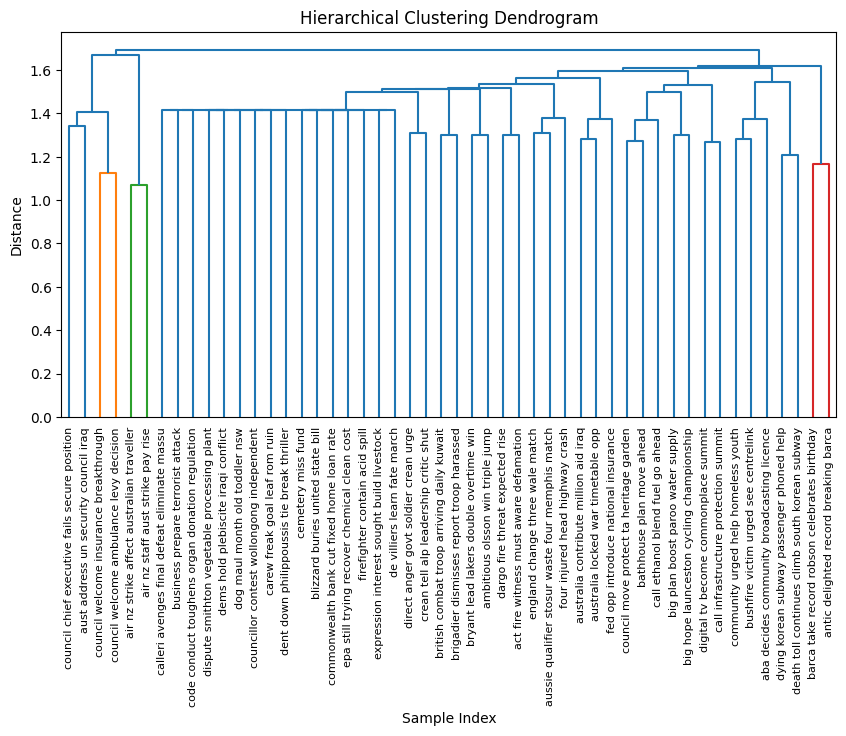

In [93]:
# finally plotting the dendrogram
plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')

dendrogram(linkage_matrix, orientation='top', labels=top_50_headlines.tolist(), distance_sort='descending', show_leaf_counts=True)
plt.show()

Q1.4. Using Latent Dirichlett Allocation algorithm, perform topic modeling to find 20 topics from the headlines. Then, print the top 10 words for each topic.

In [94]:
lda = LatentDirichletAllocation(n_components=20, random_state=42)
lda.fit(tfidf_matrix)

LatentDirichletAllocation(n_components=20, random_state=42)

In [95]:
lda.components_.shape

(20, 237)

In [47]:
# printing top 10 words for each of the 20 topics
def print_top_words(model, feature_names, n_top_words):
  for topic_idx, topic in enumerate(model.components_):
    print("Topic {}: {}".format(topic_idx+1, ", ".join([feature_names[word] for word in topic.argsort()[:-n_top_words -1:-1]])))

tfidf_feature_names = vectorizer.get_feature_names_out()
print_top_words(lda, tfidf_feature_names, 10)

Topic 1: fund, miss, cemetery, independent, contest, wollongong, councillor, goal, freak, ruin
Topic 2: aba, broadcasting, licence, decides, change, three, wale, england, water, boost
Topic 3: youth, homeless, vegetable, plant, processing, dispute, smithton, community, help, urged
Topic 4: avenges, calleri, defeat, final, massu, eliminate, council, england, fed, fate
Topic 5: barca, record, antic, breaking, delighted, contribute, million, aid, fate, de
Topic 6: harassed, dismisses, brigadier, report, troop, chemical, still, clean, cost, trying
Topic 7: crash, head, highway, injured, phoned, dying, passenger, four, subway, korean
Topic 8: victim, see, centrelink, bushfire, direct, govt, soldier, urge, anger, urged
Topic 9: iraqi, plebiscite, dems, conflict, hold, south, climb, death, toll, continues
Topic 10: council, rise, insurance, nz, australia, big, plan, opp, air, crean
Topic 11: business, terrorist, attack, prepare, stosur, aussie, memphis, waste, qualifier, match
Topic 12: break

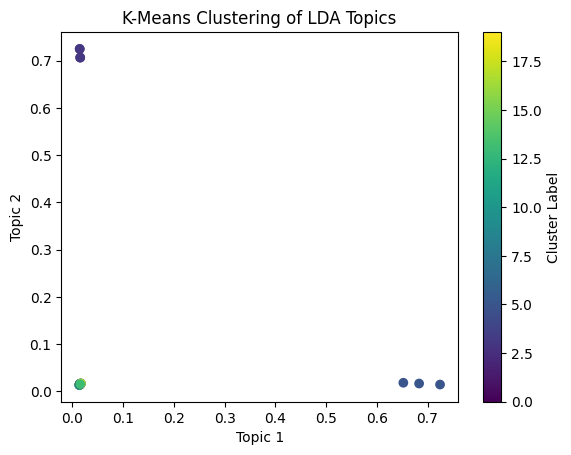

In [100]:
# Get the topic distribution for each document
topic_matrix = lda.transform(tfidf_matrix)

# Setting number of clusters as 20
num_clusters = 20

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(topic_matrix)

# Visualize the clusters using a scatter plot (using only the first two dimensions)
plt.scatter(topic_matrix[:, 0], topic_matrix[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering of LDA Topics')
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.colorbar(label='Cluster Label')
plt.show()

Q1.5. Using Non-Negative Matrix Factorization algorithm, perform topic modeling to find 20 topics from the headlines. Then, print the top 10 words for each topic.

In [103]:
nfm_model = NMF(n_components=20, random_state=42)
nfm_model.fit(tfidf_matrix)

NMF(n_components=20, random_state=42)

In [101]:
print_top_words(nfm_model, tfidf_feature_names, 10)

Topic 1: council, welcome, breakthrough, levy, decision, ambulance, insurance, fails, executive, position
Topic 2: strike, air, nz, australian, affect, traveller, staff, pay, aust, rise
Topic 3: subway, korean, dying, phoned, passenger, toll, continues, climb, death, south
Topic 4: ahead, move, bathhouse, plan, go, fuel, ethanol, blend, call, heritage
Topic 5: record, barca, delighted, breaking, antic, robson, celebrates, birthday, take, dems
Topic 6: summit, call, infrastructure, protection, commonplace, tv, digital, become, fuel, ethanol
Topic 7: opp, national, fed, introduce, insurance, war, locked, timetable, australia, breakthrough
Topic 8: four, match, qualifier, stosur, waste, aussie, memphis, crash, head, highway
Topic 9: urged, community, youth, homeless, help, bushfire, centrelink, victim, see, broadcasting
Topic 10: troop, harassed, dismisses, report, brigadier, arriving, kuwait, daily, combat, british
Topic 11: fire, expected, threat, dargo, rise, witness, defamation, act, 

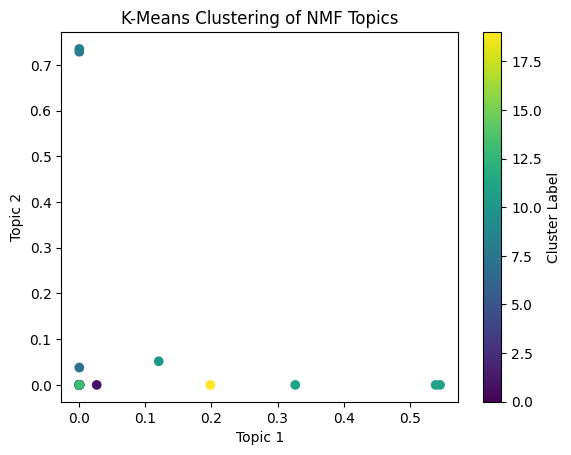

In [104]:
# Get the topic distribution for each document
topic_matrix = nfm_model.fit_transform(tfidf_matrix)

# Setting number of clusters as 20
num_clusters = 20

# Apply K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(topic_matrix)

# Visualize the clusters using a scatter plot (using only the first two dimensions)
plt.scatter(topic_matrix[:, 0], topic_matrix[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering of NMF Topics')
plt.xlabel('Topic 1')
plt.ylabel('Topic 2')
plt.colorbar(label='Cluster Label')
plt.show()

<div class="alert alert-block alert-info">

# Part 2: Reflection
    
</div>

As a second step—after answering the questions, include the following:
1. A reflection of your experience performing the activity.
2. A reflection on the importance of learning this activity.
**Note:** include your reflection in this notebook as markdown cells.

**1. A reflection of your experience performing the activity.**

I gained practical experience in several important areas of natural language processing such as preprocessing text, topic modeling, and document clustering. Each step of the activity - from cleaning and preparing data to applying algorithms like Latent Dirichlet Allocation (LDA) and Non-Negative Matrix Factorization (NMF) — helped deepen my understanding of how these techniques work in real-world contexts. I faced some challenges, such as handling errors during vectorization and getting the right slicing methods. These issues taught me how to debug and refine my approach. Overall, it was a valuable hands-on experience in working with large datasets and complex algorithms.

**2. A reflection on the importance of learning this activity.**

It helps develops both technical and problem-solving skills that are necessary in many real-world applications of NLP. For example, being able to perform topic modeling allows us to extract meaningful patterns from unstructured data, which is valuable in fields like customer support, information retrieval, and content recommendation systems. This activity also helps in understanding how to preprocess data properly and apply models like LDA or NMF which is foundational for tasks such as document classification, sentiment analysis, and chatbot development.








<div class="alert alert-block alert-info">

# Submission
    
</div>

Submit **Lab4.ipynb** to the **Lab 4 – Topic Modeling (Dropbox)** on D2L by the due date.

<div class="alert alert-block alert-info">

# Grading Rubric
    
</div>

| Criterion                            | Excellent                                             | Good                                                  | Average                                                   | Below Average                                                | Poor                                                         | No Attempt                               |
|--------------------------------------|------------------------------------------------------|-------------------------------------------------------|-----------------------------------------------------------|-------------------------------------------------------------|--------------------------------------------------------------|------------------------------------------|
| **Part 1:** Activity-Question 1.1    | **10 points** - Completes all aspects of the question correctly | **8 points** - Completes most aspects of the question correctly | **6 points** - Completes aspects of the question correctly, and some incorrectly | **4 points** - Completes most aspects of the question incorrectly or does not attempt many aspects | **2 points** - Minimal effort or completes a few aspects of the question or very few correctly | **0 points** - Did not complete the question |
| **Part 1:** Activity-Question 1.2    | **10 points** - Completes all aspects of the question correctly | **8 points** - Completes most aspects of the question correctly | **6 points** - Completes aspects of the question correctly, and some incorrectly | **4 points** - Completes most aspects of the question incorrectly or does not attempt many aspects | **2 points** - Minimal effort or completes a few aspects of the question or very few correctly | **0 points** - Did not complete the question |
| **Part 1:** Activity-Question 1.3    | **10 points** - Completes all aspects of the question correctly | **8 points** - Completes most aspects of the question correctly | **6 points** - Completes aspects of the question correctly, and some incorrectly | **4 points** - Completes most aspects of the question incorrectly or does not attempt many aspects | **2 points** - Minimal effort or completes a few aspects of the question or very few correctly | **0 points** - Did not complete the question |
| **Part 1:** Activity-Question 1.4    | **10 points** - Completes all aspects of the question correctly | **8 points** - Completes most aspects of the question correctly | **6 points** - Completes aspects of the question correctly, and some incorrectly | **4 points** - Completes most aspects of the question incorrectly or does not attempt many aspects | **2 points** - Minimal effort or completes a few aspects of the question or very few correctly | **0 points** - Did not complete the question |
| **Part 1:** Activity-Question 1.5    | **10 points** - Completes all aspects of the question correctly | **8 points** - Completes most aspects of the question correctly | **6 points** - Completes aspects of the question correctly, and some incorrectly | **4 points** - Completes most aspects of the question incorrectly or does not attempt many aspects | **2 points** - Minimal effort or completes a few aspects of the question or very few correctly | **0 points** - Did not complete the question |
| **Part 2:** Reflection                | **10 points** - Reflection clearly ties to the module content; experience and importance clearly laid out | **8 points** - Reflection mostly ties to the module content; experience & importance are discussed | **6 points** - Reflection ties minimally to the module content; experience & importance are discussed but not thoroughly | **4 points** - Reflection does not tie to the module content; experience & importance are minimally discussed | **2 points** - Minimal effort to tie to content; minimal effort to describe experience/importance | **0 points** - Did not complete the reflection |
